In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import seaborn as sns
import glob

# Contents

In this tutorial, we will perform classification of 2D slices into FLAIR and T1 images using deep learning. Building up on last week's tutorial, here are a few concepts explained in this tutorial:

<ul>
    <li>Loading data from files and dynamic data augmentation within dataloaders</li>
    <li>Defining the transforms for data augmentation on your own</li>
    <li>Early stopping and checkpointing the model while training</li>
    <li>Learning hook functions</li>
    <li>Debugging and predicting features at intermediate layers</li>
    <li>Visualisation of features at a given layer using a t-stochastic neighbourhood embedding (t-SNE) plot </li>
    <li>Fine-tuning a pre-trained model, freezing layers</li>
</ul>

First, we check for the type of device available.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Now we define the hyper-parameters used in the training and fine-tuning. Observe the new parameters that have been added in addition to the ones used last week.

In [3]:
class Args:
    def __init__(self):
        self.batch_size = 16
        self.log_interval = 10
        self.learning_rate = 1e-2
        self.finetuning_learning_rate = 1e-3
        self.train_prop = 0.8
        self.val_prop = 0.1
        self.epochs = 25
        self.finetuning_epochs = 20
        self.patience = 12 # For early stopping
args = Args()

## Loading data from files and dynamic data augmentation within dataloaders

For this experiment, I have used the Brain tumour segmentation 2020 (BraTS 2020)$^{[1,2,3]}$. Our objective to extract 2D slices from volumes and classify the slices into FLAIR and T1. Last week, we had already loaded the dataset and prepared the numpy array for you. Here, we show you how to load the volumes from a directory, form numpy array and get dataloaders. The FLAIR and T1 images are read from numpy dictionaries in the directory (use nibabel if you have nifti files for your own project).

References:

[1] B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) DOI: 10.1109/TMI.2014.2377694
[2] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117
[3] S. Bakas, M. Reyes, A. Jakab, S. Bauer, M. Rempfler, A. Crimi, et al., "Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge", arXiv preprint arXiv:1811.02629 (2018)

The data has been brain extracted, cropped tightly around the brain and resized to size (64, 64, 64). We have single channel images (FLAIR/T1) as input and for 2D pytorch takes the input in the form (num_samples, num_channels, x_dim, y_dim).

Here we define the function for preprocessing the data: removing extreme values in the images and perform Gaussian normalization.

In [4]:
import glob
from sklearn.utils import shuffle

def normalise_data(X):
    X = X / np.percentile(X, 99.9)
    X[X > 1] = 1
    X = X - np.mean(X)
    std_dev = np.std(X[X>0])
    X = X/std_dev
    return X

Here is where we actually data from the the files in the directory and form a stack of 2D slices.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_files = glob.glob('/content/drive/My Drive/Week2_material/Week2_data/*.npz')

In [5]:
Xflair = np.array([])
Xt1 = np.array([])
y = []
for i in range(len(data_files)):
    obj = np.load(data_files[i])
    Xflair = np.concatenate([Xflair,normalise_data(obj['flair'])], axis=-1) if Xflair.size else normalise_data(obj['flair'])
    Xt1 = np.concatenate([Xt1,normalise_data(obj['t1'])], axis=-1) if Xt1.size else normalise_data(obj['t1'])

Xflair = Xflair.transpose(2,0,1) # Getting into C x H x W format used in pytorch
Xt1 = Xt1.transpose(2,0,1) # Getting into C x H x W format used in pytorch
X = np.concatenate([np.array(Xflair),np.array(Xt1)],axis=0)

# Make y a one-shot label vector with (0,1) for FLAIR and (1,0) for T1 volumes
yflair = np.hstack([np.zeros([len(Xflair),1]), np.ones([len(Xflair),1])])
yt1 = np.hstack([np.ones([len(Xt1),1]), np.zeros([len(Xt1),1])])
y = np.concatenate([np.array(yflair),np.array(yt1)],axis=0)
print(np.sum(y, axis=0))

# Shuffle the data to mix them up well
X, y = shuffle(X, y, random_state=0)

# Scale the data values
print(X.shape, y.shape)

[9856. 9856.]
(19712, 64, 64) (19712, 2)


Split the data into trainng, validation and test samples using the training and validation data proportion in the args.

In [6]:
X = np.reshape(X, (-1, 1, 64, 64))

no_train_samples = int(len(X) * args.train_prop)
no_val_samples = int(len(X) * args.val_prop)
trainX = X[:no_train_samples,...]
valX = X[no_train_samples:no_train_samples+no_val_samples,...]
testX = X[no_train_samples+no_val_samples:,...]

trainy = y[:no_train_samples,...]
valy = y[no_train_samples:no_train_samples+no_val_samples,...]
testy = y[no_train_samples+no_val_samples:,...]

print("Training data size: ")
print(trainX.shape, trainy.shape)

print("Validation data size: ")
print(valX.shape, valy.shape)

print("Test data size: ")
print(testX.shape, testy.shape)

Training data size: 
(15769, 1, 64, 64) (15769, 2)
Validation data size: 
(1971, 1, 64, 64) (1971, 2)
Test data size: 
(1972, 1, 64, 64) (1972, 2)


total number of FLAIR and T1 training images:  [7918. 7851.]


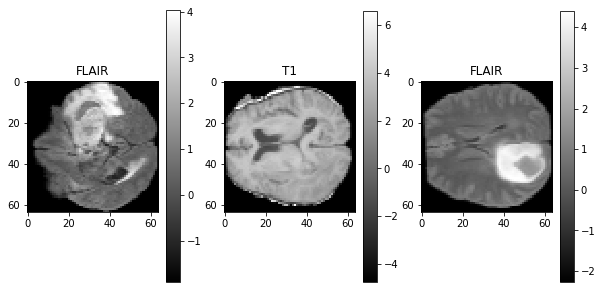

In [15]:
# Plotting the data for a sample training subject
print('total number of FLAIR and T1 training images: ', np.sum(trainy, axis=0))

plt.figure(figsize=(10,5))
subj=800
plt.subplot(1,3,1)
modality = 'FLAIR' if trainy[subj,1] == 1 else 'T1'
plt.imshow(trainX[subj, 0, :, :], cmap='gray')
plt.title(modality)
plt.colorbar()

subj=7000    
plt.subplot(1,3,2)
modality = 'FLAIR' if trainy[subj,1] == 1 else 'T1'
plt.imshow(trainX[subj, 0, :, :], cmap='gray')
plt.title(modality)
plt.colorbar()

subj = 8000
plt.subplot(1,3,3)
modality = 'FLAIR' if trainy[subj,1] == 1 else 'T1'
plt.imshow(trainX[subj, 0, :, :], cmap='gray')
plt.title(modality)
plt.colorbar()
plt.show()

A few random samples are plotted with their true labels. Look out for the intensity ranges after the Gaussian normalisation. 

Now, we create the dataset with added data augmentation. The transforms to be used in data augmentation is passed as an argument to DatasetwithAug() class as shown in the next section. 

In [16]:
from torch.utils.data import Dataset

class DatasetwithAug(Dataset):  # Inherit from Dataset class
    """This is a generic class for 3D segmentation datasets.
    :param filename_pairs: a list of tuples in the format (input filename,
                           ground truth filename).
    :param cache: if the data should be cached in memory or not.
    :param transform: transformations to apply.
    """
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).float()
        self.transform = transform # This is where you can add augmentations

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)
            x = x.float()

        return x, y

    def __len__(self):
        return len(self.data)

## Defining the transforms for data augmentation on your own

Now there are many in-built transforms available in torchvision.transforms for 2D images: https://pytorch.org/docs/stable/torchvision/transforms.html (a couple of example calls are shown commented out in the code below). 

Additionally, to show how to define your own transform, here are two transform classes defined: ToTensor() and RandomTranslation2D() and compose the combined transform. We pass this combined transform as an arguement to the DatasetwithAug() class.

In [17]:
from torchvision import transforms
from torch.utils.data import DataLoader
import random
from scipy.ndimage.interpolation import shift
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate, zoom

# In-built pytorch transforms
# If you are using 2D images, composing transforms for augmentation using in-built transformations available in torchvision.transforms
# A sample composed trasform is shown below
# For details, refer to https://pytorch.org/docs/stable/torchvision/transforms.html 
# composed_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomAffine(degrees=0, translate=[0.1,0.2]),
#     transforms.RandomRotation(8),
#     transforms.ToTensor(),
#     ])

# Another example of in-built transforms. You can add any number fo transforms:
# transform = transforms.Compose([
#      transforms.ToPILImage(),
#      transforms.Resize((300, 300)),
#      transforms.CenterCrop((100, 100)),
#      transforms.RandomCrop((80, 80)),
#      transforms.RandomHorizontalFlip(p=0.5),
#      transforms.RandomRotation(degrees=(-90, 90)),
#      transforms.RandomVerticalFlip(p=0.5),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#      ])

# Now compose a transform for a 2D image
class ToTensor(object):
    """Convert a PIL image or numpy array to a PyTorch tensor."""

    def __init__(self, labeled=True):
        self.labeled = labeled

    def __call__(self, input_data):
        ret_input = torch.from_numpy(input_data).float()

        return ret_input

class RandomTranslation2D(object):
    """Translate the volume's values.
    :param degrees: maximum of translation values.
    """
    def __init__(self, offsets, axis=0):
        self.offsets = offsets
        self.order = 5

    @staticmethod
    def get_params(offsets):
        offsetx = np.random.uniform(offsets[0], offsets[1])
        offsety = np.random.uniform(offsets[2], offsets[3])
        return offsetx, offsety
    
    def __call__(self, input_data):
        if len(input_data.shape) != 3:
            raise ValueError("Input of RandomRotation3D should be a 3 dimensionnal tensor.") # C x H x W

        offsetx, offsety = self.get_params(self.offsets)
        translated_im = np.zeros(input_data.shape)
        translated_im[0,:,:] = shift(input_data[0,:,:], (offsetx, offsety), order=self.order, mode='nearest')
        
        return translated_im
    
composed_transforms = transforms.Compose([
            RandomTranslation2D([-10,10,-10,10]), 
            ToTensor(),
        ])

# We create training and validation datasets with the composed transforms
train_datadict = DatasetwithAug(trainX, trainy, composed_transforms)
val_datadict = DatasetwithAug(valX, valy, composed_transforms)

train_dataloader = DataLoader(train_datadict, batch_size=args.batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_datadict, batch_size=args.batch_size, shuffle=False, num_workers=0)

### Exercise 1: As observed from the composed transform above, the composed_transform will perform the individual transforms in the specified order (using randomly chosed parameter values from the range provided). Now can we choose the transforms in random to be applied?
#### Hint:
Use a dictionary of transforms

We now define the model. We use the three standard parts in the definition of the model as discussed last week: init part, forward pass and (backward pass which calculated automatically through autograd function).

This week, we use nn.Sequential() method to define the model, instead of using static functions within the class. We can also use a mixture of nn.Sequential and static function definitions (if a particular module/layer is repeated often - shown in the next tutorial).

Last week, we used a U-Net model for segmentation. This week we will use another popular model, VGG-16 model (https://arxiv.org/pdf/1409.1556.pdf), for classification. The model architecture consists of two main parts:
<ul>
    <li> The encoder part, which is slightly modified to be 12 layers deep (counting the convolutional and a pooling layers) instead of standard 13 layers</li>
    <li> Two fully connected layers </li>
</ul>

We provide three inputs to the model: 
<ul>
    <li> in_channels: number of input channels, since we use only single modalities, this is 1. </li>
    <li> out_channels: We have two labels for task: FLAIR and T1. So out_channels = 2. </li>
    <li> init_features: ideally, we would provide this value (i.e. number of filters) to be at least 64 and increase the number of filters by the factor of 2 after each pooling layer. However, more features does result in more parameters and hence for reducing computational complexity to be run on CPU, we specify a smaller value of 4.</li>
</ul>

In [18]:
class VGGClassModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, init_features=4):
        super(VGGClassModel, self).__init__()
        self.feature = nn.Sequential()      # Define the feature extractor
        self.feature.add_module('f_conv1_1', nn.Conv2d(1, init_features, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_1_1', nn.ReLU(True))
        self.feature.add_module('f_bn1_1', nn.BatchNorm2d(init_features))
        self.feature.add_module('f_conv1_2', nn.Conv2d(init_features, init_features, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_1_2', nn.ReLU(True))
        self.feature.add_module('f_bn1_2', nn.BatchNorm2d(init_features))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))

        self.feature.add_module('f_conv2_1', nn.Conv2d(init_features, init_features*2, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_2_1', nn.ReLU(True))
        self.feature.add_module('f_bn2_1', nn.BatchNorm2d(init_features*2))
        self.feature.add_module('f_conv2_2', nn.Conv2d(init_features*2, init_features*2, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_2_2', nn.ReLU(True))
        self.feature.add_module('f_bn2_2', nn.BatchNorm2d(init_features*2))
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))

        self.feature.add_module('f_conv3_1', nn.Conv2d(init_features*2, init_features*2, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_3_1', nn.ReLU(True))
        self.feature.add_module('f_bn3_1', nn.BatchNorm2d(init_features*2))
        self.feature.add_module('f_conv3_2', nn.Conv2d(init_features*2, init_features*2, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_3_2', nn.ReLU(True))
        self.feature.add_module('f_bn3_2', nn.BatchNorm2d(init_features*2))
        self.feature.add_module('f_pool3', nn.MaxPool2d(2))

        self.feature.add_module('f_conv4_1', nn.Conv2d(init_features*2, init_features*3, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_1', nn.ReLU(True))
        self.feature.add_module('f_bn4_1', nn.BatchNorm2d(init_features*3))
        self.feature.add_module('f_conv4_2', nn.Conv2d(init_features*3, init_features*3, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_2', nn.ReLU(True))
        self.feature.add_module('f_bn4_2', nn.BatchNorm2d(init_features*3))
        self.feature.add_module('f_conv4_3', nn.Conv2d(init_features*3, init_features*3, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_3', nn.ReLU(True))
        self.feature.add_module('f_bn4_3', nn.BatchNorm2d(init_features*3))
        self.feature.add_module('f_pool4', nn.MaxPool2d(2))

        self.feature.add_module('f_conv5_1', nn.Conv2d(init_features*3, init_features*3, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_1', nn.ReLU(True))
        self.feature.add_module('f_bn5_1', nn.BatchNorm2d(init_features*3))
        self.feature.add_module('f_conv5_2', nn.Conv2d(init_features*3, init_features*3, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_2', nn.ReLU(True))
        self.feature.add_module('f_bn5_2', nn.BatchNorm2d(init_features*3))
        self.feature.add_module('f_conv5_3', nn.Conv2d(init_features*3, init_features*3, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_3', nn.ReLU(True))
        self.feature.add_module('f_bn5_3', nn.BatchNorm2d(init_features*3))
        self.feature.add_module('f_pool5', nn.MaxPool2d(2))

        self.embeddings = nn.Sequential()
        self.embeddings.add_module('r_fc1', nn.Linear(48, init_features*3))
        self.embeddings.add_module('r_relu1', nn.ReLU(True))
        
        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc2', nn.Linear(init_features*3, init_features))
        self.regressor.add_module('r_relu2', nn.ReLU(True))
        self.regressor.add_module('r_pred', nn.Linear(init_features, out_channels))


    def forward(self, x):
        feature = self.feature(x)
        feature = feature.view(-1, 48)
        feature_embedding = self.embeddings(feature)
        regression = self.regressor(feature_embedding)
        return regression

After defining the model, we now intialise an instance of the model class. We need to move the model to the device (which is CPU, of GPU if available).

In [19]:
class_model = VGGClassModel(in_channels=1, out_channels=2, init_features=4)
class_model.to(device=device)

VGGClassModel(
  (feature): Sequential(
    (f_conv1_1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (f_relu_1_1): ReLU(inplace=True)
    (f_bn1_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_conv1_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (f_relu_1_2): ReLU(inplace=True)
    (f_bn1_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (f_conv2_1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (f_relu_2_1): ReLU(inplace=True)
    (f_bn2_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_conv2_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (f_relu_2_2): ReLU(inplace=True)
    (f_bn2_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool2): MaxPool

We define the loss function (and move it to the device). Here we use the in-built cross-entropy loss function available in pytorch. And we specify the the parameters to be handled by the optimiser and the optimisation algorithm. 

In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
criterion.to(device=device)
optimizer = optim.Adam(list(class_model.parameters()), lr=args.learning_rate, eps=1e-04)

We define the classification accuracy to observe the accuracy on validation dataset while training.

In [21]:
def determine_class_accuracy(pred, target_vect):
    smooth = 1.
    pred_vect = torch.argmax(pred, dim=1)
#     target_vect = torch.argmax(target, dim=1)
    correct_cases = pred_vect == target_vect
    true_pos = correct_cases.sum()
    accuracy = true_pos/pred_vect.size()[0]
    return accuracy

## Early stopping and checkpointing the model while training

Early stopping and checkpointing is really helpful when we need to work on clusters (or any resource constrained environment) and alerts the user and saves the model when the performance of the model starts to detoriate while training. 

Early-stopping is used to avoid over-training of the model. The objective of early stopping is to stop the training of the model at an appropriate point (or epoch) beyond which the model performance would start to decrease (and the generalisation error would increase on a held-out validation data), even if the total number of specified epochs have not yet reached. The validation loss value, as a measure of the generalisation error is used to determine the early stopping point. Ideally the validation ero should decrease with each epoch, however if the validation error increases for a given epoch, the early stopping counter activates and waits until N number of epochs (specified as patience value in the arg() class) and stopping training.

Another crucial thing to do is to save the model at specific checkpoints (e.g. ever N epochs, when best performance is reached or the simplest case of saving the last epoch).

Here we combine the early stopping and model checkpointing in the following EarlyStoppingModelCheckpointing() class definition. This class has three parts: init (where values are initialised), call (which is called  during each epoch) and save_checkpoint which is called as long as the validation loss decreases.

In [22]:
class EarlyStoppingModelCheckpointing:
    # Early stops the training if the validation loss doesnt improve after a given patience
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH)
        elif score < self.best_score: # Here is the criteria for activation of early stopping counter.
            self.counter += 1
            print('Early Stopping Counter: ', self.counter, '/', self.patience)
            if self.counter >= self.patience: # When the counter reaches the patience value, early stopping flag is activated to stop the training.
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH):
            # Saves the model when the validation loss decreases
            if self.verbose:
                print('Validation loss decreased; Saving model ...')
#             # if you want to save only the model weights for the last epoch before early counter activates
#             torch.save(model.state_dict(), MODEL_PATH + 'VGG_weights_only_finalepoch' + str(epoch) + '.pth')
            # or if you want to save the model weights every N epoch (e.g. N=2) before early counter activates
            if (epoch%1) == 0: 
                torch.save(model.state_dict(),MODEL_PATH + 'VGG_weights_only_epoch' + str(epoch) + '.pth')
#                 torch.save(model, MODEL_PATH + 'VGG_full_modelepoch' + str(epoch)) # saving the whole model
#             # or if you want to save the model weights that gives best validation dice meas. value 
#             # before early counter activates
#             if val_acc > best_val_acc:
#                 torch.save(model.state_dict(),MODEL_PATH + 'VGG_weights_only_bestdice_epoch' + str(epoch) + '.pth')
# #                 torch.save(model, MODEL_PATH + 'VGG_FCN_full_model_bestdice_epoch' + str(epoch))

Cool! We now have everything ready to start training :) However, as we did last week, I have saved some weights in case you wanna skip training (took about 45 secs per epoch on my laptop). 

In [23]:
# Training and Validation

from torch.autograd import Variable

MODEL_PATH = 'models/'

# Initialise early stopping
early_stopping = EarlyStoppingModelCheckpointing(args.patience, verbose=False)

loss_store = []
for epoch in range(1, args.epochs+1):
    print('Epoch ', epoch, '/', args.epochs, flush=True)

    # First train 
    total_loss = 0
    val_total_loss = 0
    class_model.train()      #Put the model in training mode
    batches = 0
    val_dice_accuracy = 0
    best_val_dice_accuracy = 0
    for batch_idx, (data, label) in enumerate(train_dataloader): # get data for each class
        data = data.to(device=device).float()
        label = label.to(device=device).float()
        data = Variable(data)
        label = Variable(label)    # This calls autograd on our data
        if list(data.size())[0] == args.batch_size :   
            batches += 1
            # Forward
            optimizer.zero_grad()
            class_pred = class_model.forward(data)
            # Calc loss
            label = torch.argmax(label, dim=1).long()
            train_loss = criterion(class_pred, label)
            # Backprop the loss
            train_loss.backward()
            optimizer.step()
            total_loss += train_loss
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(train_dataloader.dataset),
                           100. * (batch_idx+1) / len(train_dataloader), train_loss.item()), flush=True)
    
    av_loss = (total_loss / batches).detach().cpu().numpy()   # If you dont detach it keeps the whole model
    print('Training set: Average loss: ',  av_loss, flush=True) 
    
    # Now val
    class_model.eval()
    batches = 0 
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_dataloader):
            data = data.to(device=device)
            label = label.to(device=device)
            data = Variable(data)
            label = Variable(label)
            if list(data.size())[0] == args.batch_size:
                batches += 1
                pred_class = class_model.forward(data)
                label = torch.argmax(label, dim=1).long()
                loss = criterion(pred_class, label)
                dice_accuracy = determine_class_accuracy(pred_class, label)
                val_total_loss += loss
                val_dice_accuracy += dice_accuracy 
    val_av_loss = (val_total_loss / batches).detach().cpu().numpy()
    val_dice_accuracy = (val_dice_accuracy / batches).detach().cpu().numpy()
    print('Validation set: Average loss: ',  val_av_loss, flush=True)
    print('Validation set: Average accuracy: ',  val_dice_accuracy, flush=True)
    
    loss_store.append([av_loss, val_av_loss])   # Save the losses so we can plot them
    
    # Now call the early_stopping instance for each epoch, passing in the validation loss and epoch
    # We also specify the accuracy value in case you want to save the epoch that gives the best accuracy
    # And MODEL_PATH for saving the model weights at a specific checkpoint. Currently the model weights are 
    # saved for every epoch before ES activates.    
    early_stopping(val_av_loss, val_dice_accuracy, best_val_dice_accuracy, class_model, epoch, optimizer, av_loss, MODEL_PATH)
        
    if val_dice_accuracy > best_val_dice_accuracy:
        best_val_dice_accuracy = val_dice_accuracy
        
    if early_stopping.early_stop: # Okay, when the patience is reached and early_stop flag is True, we stop training.
        loss_store = np.array(loss_store)
#         np.save(LOSS_PATH, loss_store)
        break
        # If you want the system to terminate at this point, you can use sys.exit; very handy when running 
        # codes in clusters
        sys.exit('Patience Reached - Early Stopping Activated')

    torch.cuda.empty_cache()  # Clear memory cache

Epoch  1 / 25
Train Epoch: 1 [16/15769 (0%)]	Loss: 0.768145
Train Epoch: 1 [1616/15769 (10%)]	Loss: 0.480930
Train Epoch: 1 [3216/15769 (20%)]	Loss: 0.252845
Train Epoch: 1 [4816/15769 (31%)]	Loss: 0.205394
Train Epoch: 1 [6416/15769 (41%)]	Loss: 0.444407
Train Epoch: 1 [8016/15769 (51%)]	Loss: 0.194461
Train Epoch: 1 [9616/15769 (61%)]	Loss: 0.101010
Train Epoch: 1 [11216/15769 (71%)]	Loss: 0.147478
Train Epoch: 1 [12816/15769 (81%)]	Loss: 0.278966
Train Epoch: 1 [14416/15769 (91%)]	Loss: 0.251767
Training set: Average loss:  0.27029532
Validation set: Average loss:  0.23173651
Validation set: Average accuracy:  0
Epoch  2 / 25
Train Epoch: 2 [16/15769 (0%)]	Loss: 0.452276
Train Epoch: 2 [1616/15769 (10%)]	Loss: 0.097586
Train Epoch: 2 [3216/15769 (20%)]	Loss: 0.059303
Train Epoch: 2 [4816/15769 (31%)]	Loss: 0.233464
Train Epoch: 2 [6416/15769 (41%)]	Loss: 0.041400
Train Epoch: 2 [8016/15769 (51%)]	Loss: 0.123839
Train Epoch: 2 [9616/15769 (61%)]	Loss: 0.045089
Train Epoch: 2 [11216/1

Training set: Average loss:  0.049149696
Validation set: Average loss:  0.034487333
Validation set: Average accuracy:  0
Early Stopping Counter:  3 / 12
Epoch  14 / 25
Train Epoch: 14 [16/15769 (0%)]	Loss: 0.049128
Train Epoch: 14 [1616/15769 (10%)]	Loss: 0.053919
Train Epoch: 14 [3216/15769 (20%)]	Loss: 0.035933
Train Epoch: 14 [4816/15769 (31%)]	Loss: 0.009324
Train Epoch: 14 [6416/15769 (41%)]	Loss: 0.001592
Train Epoch: 14 [8016/15769 (51%)]	Loss: 0.081063
Train Epoch: 14 [9616/15769 (61%)]	Loss: 0.001159
Train Epoch: 14 [11216/15769 (71%)]	Loss: 0.130540
Train Epoch: 14 [12816/15769 (81%)]	Loss: 0.028603
Train Epoch: 14 [14416/15769 (91%)]	Loss: 0.067307
Training set: Average loss:  0.036493644
Validation set: Average loss:  0.025677398
Validation set: Average accuracy:  0
Epoch  15 / 25
Train Epoch: 15 [16/15769 (0%)]	Loss: 0.001939
Train Epoch: 15 [1616/15769 (10%)]	Loss: 0.018881
Train Epoch: 15 [3216/15769 (20%)]	Loss: 0.068808
Train Epoch: 15 [4816/15769 (31%)]	Loss: 0.023517

### Excercise 2: In case you are working on the time-constrained environment (e.g. a cluster where each job can run only for short duration, say 20 minutes) how would you train the model without having to start-over?

#### Hint: 
In addition to early stopping, save the entire model (including optimiser and loss) at the end each epoch and load the model at the beginning of each epoch.

(2, 25)


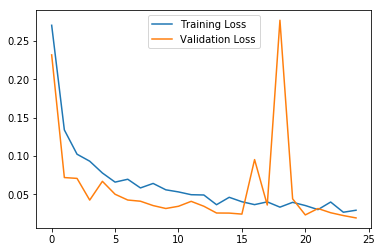

In [24]:
# sns.set()
loss_store = np.array(loss_store).T
print(loss_store.shape)
plt.plot(loss_store[0,:])
plt.plot(loss_store[1,:])
plt.legend(['Training Loss', 'Validation Loss'])

We now predict the test dataset using the model to check if the model is performing well. The test dataset does not require augmentation, however, we define the test dataset with just ToTensor() as our transform (since we want to convert the arrays to tensors).

Get the predictions (with just forward pass and evoking .eval() mode of the model) and stack the the resulting arrays.

In [25]:
# pretrained_dict = torch.load(MODEL_PATH + 'VGG_weights_only_epoch25.pth')
# testclass_model = VGGClassModel(in_channels=1, out_channels=2, init_features=4)
# testclass_model.load_state_dict(pretrained_dict)

testclass_model = class_model

classification_results = []
testdata = []
testlabels = []
testclass_model.eval()

test_transform = ToTensor()

test_datadict = DatasetwithAug(testX, testy, test_transform)
test_dataloader = DataLoader(test_datadict, batch_size=1, shuffle=False, num_workers=0)
with torch.no_grad():
    for (data, label) in test_dataloader:
        data = data.to(device=device)
        label = label.to(device=device)
        data = Variable(data)
        label = Variable(label)
        preds = testclass_model.forward(data)
        classification_results.append(preds.detach().cpu().numpy())
        testdata.append(data.detach().cpu().numpy())
        testlabels.append(label.detach().cpu().numpy())

We determine the classification accuracy and show the result for a sample subject. Change the 'subj' value and observe for a few more subjects.

(1972, 2) (1972, 64, 64) (1972, 2)
Number of FLAIR and T1 instances:  [ 957. 1015.]
Test accuracy:  0.9893509127789046
Target_label:  FLAIR
Predicted_label:  FLAIR
[1 0 0 ... 1 0 1] [1 0 0 ... 1 0 1]


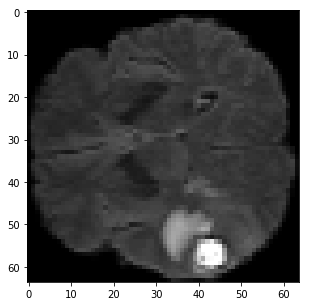

In [26]:
# Converting lists to array and removing any additional dimensions
classification_results = np.array(classification_results).squeeze()
testdata = np.array(testdata).squeeze()
testlabels = np.array(testlabels).squeeze()

print(classification_results.shape, testdata.shape, testlabels.shape)
print('Number of FLAIR and T1 instances: ', np.sum(testlabels, axis=0))

# getting the predicted classes: One-shot labels of [0,1] and [1,0] are FLAIR and T1 respectively. 
# Hence, argmax value of 1 would be 'FLAIR' class and 0 would be 'T1' class.
classification_vector = np.argmax(classification_results, axis=1)
testlabel_vector = np.argmax(testlabels, axis=1)

# Get the accuracy value
correctly_predicted = (classification_vector == testlabel_vector).astype(float)
accuracy = np.sum(correctly_predicted)/classification_results.shape[0]

print('Test accuracy: ', accuracy)

# print(classification_results,testlabels)

subj = 100
# sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,5))
plt.imshow(testdata[subj,:,:], cmap='gray')

sub_target_label = testlabel_vector[subj]
sub_pred_lab = classification_vector[subj]

target_label = 'FLAIR' if sub_target_label else 'T1'
predicted_label = 'FLAIR' if sub_pred_lab else 'T1'
# print(sub_target_label, sub_pred_lab)
print('Target_label: ', target_label)
print('Predicted_label: ', predicted_label)

print(testlabel_vector, classification_vector)

## Learning hook functions

It is good to have a thorough understanding of pytorch autograd function before learning about hooks. You can find the documentation of autograd function here: https://pytorch.org/docs/stable/autograd.html. This blog might also help: https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/.

Hooks are functions with very specific signature that we can apply on the tensor or nn.Module. There are two types of hooks: backward and forward. Forward hooks are executed during forward pass on the forward function (not the forward function in the model class, but the forward function in Autograd.Function object) and backward hooks are executed during backward pass.

For the forward hook, the function is of the form: hook(module, input, output) -> None or Tensor output, where input is the input to the module and output is the output obtained after the input is passed through the module.

For the backward hook, the function is of the form: hook(module, grad_input, grad_output) -> Tensor or None, where grad_input is the gradient of the input to the module and grad_output is the gradient of the output of the module with respect to the Loss.

In this tutorial, we use forward hook to get the outputs of any intermediate layer of the test dataset for visualisation. The forward hook is triggered every time after the method forward (of the Pytorch AutoGrad Function grad_fn) has computed an output. We can modify the output by returning the modified output from the hook. We can also modify the input in-place but it will not have an effect on the output as this hook is triggered after the computations in the forward (of the Pytorch AutoGrad Function grad_fn) method are complete.

Here we define the hook function to get the results at a layer specified by the name of the layer. For the names of the individual layers of the model, scroll up to the model instance initialisation where the layers are displayed. This function can also be defined within the model class (since we are dealing with only one model here, it doesn't matter).

In [33]:
# a dict to store the activations
activation = {}
# We wrap the hook function within another function which takes in the name 
# which helps us to keep track of the layer we want to visualise
def getActivation(name): 
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach() #
    return hook

## Debugging and predicting features at intermediate layers

We now call the forward hook function using register_forward_hook() for the specified layers. I have collected the outputs at a few layers: conv_layer1_2, conv_layer5_3 and fully_connected_layer1. 

In [34]:
input_data, input_labels, conv1_1, conv5_3, fc1 = [], [], [], [], []
for (data, label) in test_dataloader:
    h1 = testclass_model.feature.f_conv1_2.register_forward_hook(getActivation('f_conv1_2'))
    h2 = testclass_model.feature.f_conv5_3.register_forward_hook(getActivation('f_conv5_3'))
    h3 = testclass_model.embeddings.r_fc1.register_forward_hook(getActivation('r_fc1'))
    
    out = testclass_model(data)   
    input_data.append(data.detach().numpy())
    input_labels.append(label.detach().numpy())
    
    # outputs of the layers are saved in dictionary called activation with names of layers as keys
    conv1_1.append(activation['f_conv1_2'].numpy()) 
    conv5_3.append(activation['f_conv5_3'].numpy())
    fc1.append(activation['r_fc1'].numpy())  
    
    
print(len(conv1_1), len(conv5_3), len(fc1))    

# delete hook handles
h1.remove()
h2.remove()
h3.remove()  

1972 1972 1972


I have plotted the output of first convolutional layer here (since it resembles input and will be easier to visualise). Feel free to change number of filters and subplot numbers to view the outputs of conv_layer5_3. Plots show the features for FLAIR and T1 sample inputs.

Output shape at conv_layer1_2:  (1972, 4, 64, 64)
Input data shape after removing channel dimension:  (1972, 64, 64)


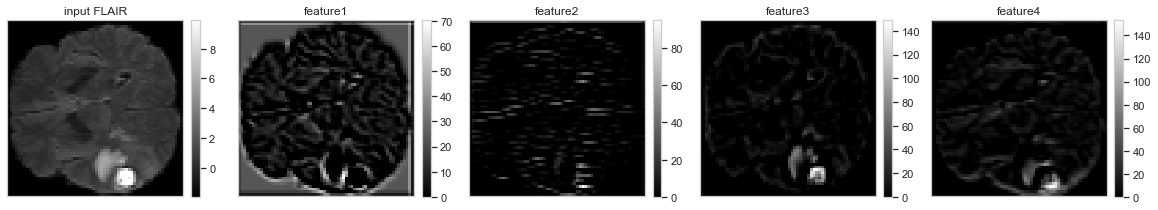

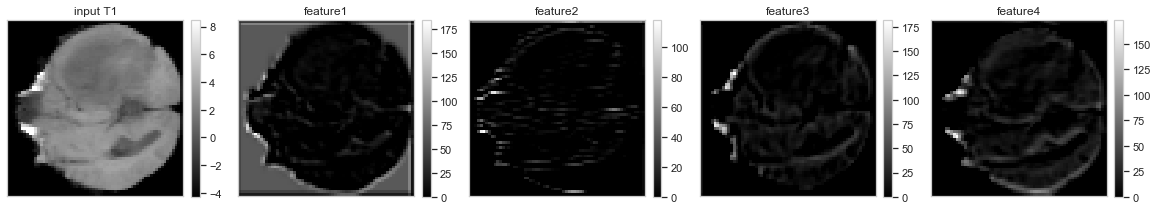

In [35]:
conv1_1 = np.array(conv1_1).squeeze()
input_data = np.array(input_data).squeeze()
input_labels = np.array(input_labels).squeeze()
print('Output shape at conv_layer1_2: ', conv1_1.shape)
print('Input data shape after removing channel dimension: ', input_data.shape)

plt.figure(figsize=(20,5))
sns.set(font_scale = 1)
sns.despine(left=True)

subj = 100
num_filt = conv1_1.shape[1]
sns.set_style("whitegrid", {'axes.grid' : False})
plt.subplot(1,5,1)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
im = ax.imshow(input_data[subj,:,:], cmap='gray')
plt.title('input FLAIR')
plt.colorbar(im,fraction=0.046, pad=0.04)

for i in range(num_filt):
    plt.subplot(1,5,i+2)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    im = ax.imshow(conv1_1[subj,i,:,:], cmap='gray')
    plt.title('feature' + str(i+1))
    plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()  

plt.figure(figsize=(20,5))

subj = 1100
plt.subplot(1,5,1)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
im = ax.imshow(input_data[subj,:,:], cmap='gray')
plt.title('input T1')
plt.colorbar(im,fraction=0.046, pad=0.04)

for i in range(num_filt):
    plt.subplot(1,5,i+2)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    im = ax.imshow(conv1_1[subj,i,:,:], cmap='gray')
    plt.title('feature' + str(i+1))
    plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show() 


## Visualisation of features at a given layer using a t-SNE plot

So far we were able to do an visual interpretation of the outputs. However, it would be more useful to determine the statistical similarity of features and their usefulness in the task.

T-SNE plot is a tool to visualise high-dimensional data. For more information refer to: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html.

<ul>
    <li> The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A. </li>
    <li> The algorithm then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space. </li>
    <li> To measure the minimization of the sum of difference of conditional probability t-SNE minimizes the sum of Kullback-Leibler divergence of overall data points using a gradient descent method. </li>
</ul>

A few important parameters in sklearn.manifold.TSNE:
<ul>
    <li> n_components: number of dimensions the data must be reduced to.</li>
    <li> perprlexity: number of nearest neighbours considered for divergence estimation. </li>
    <li> n_iter: number of iteration (must be st leat 250).
</ul>       

In [ ]:
# Getting T-SNE plots at a specific layer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Lets plot the t-SNE plot for the layer conv1_1. change layer output to any desired intermediate layers 
# obtained with register_forward_hook() attribute (e.g. conv5_3)
layer_output = conv1_1
features = np.reshape(layer_output, [layer_output.shape[0], -1])
targets = np.reshape(input_labels,[layer_output.shape[0], -1])

# When we reshape the 3D (F x H x W, where F is the number of features) featuremaps into a vector 
# for each instance, we end up with lot of features (4 x 64 x 64 in this instance).
# Hence it is advisable to perform dimension reduction with PCA first, before getting TSNE components.

pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

# Now get the t-SNE values for two components (since we want to visualise the features using a 2D plot)
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result)

target_vect = np.argmax(targets,axis=1)

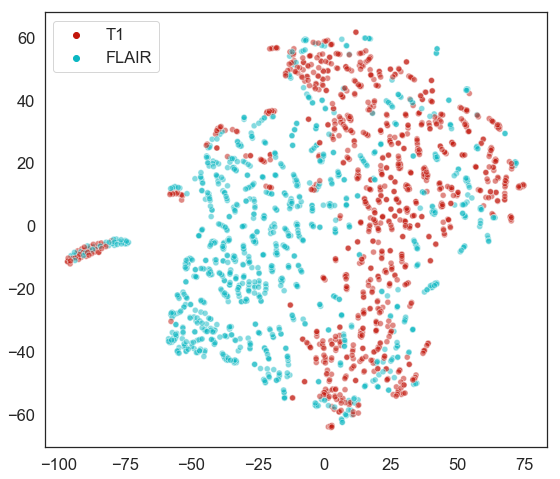

In [53]:
# Plotting the t-SNE plot
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(1,1,1)
sns.set(font_scale = 1.5)
sns.set_style("white")

ax = sns.scatterplot(
    x=tsne_pca_results[:,0], y=tsne_pca_results[:,1],
    hue=target_vect,
    palette=sns.hls_palette(2, l=.4, s=.9),
    alpha=0.5, legend='brief'
)
leg = ax.axes.get_legend()
# replace labels
new_labels = ['T1', 'FLAIR']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
plt.show()

## Bonus: Fine-tuning a pre-trained model, freezing layers

In this section, we show how to freeze and unfreeze layers, and to perform fin-tuning of models which is quite helpful in transfer learning (where you fine-tune a pre-trained model to adapt well with your data). Also, in some applications under controlled experimental conditions, after training the model, fine-tuning the trained model (on the same training dataset) after freezing the initial layers has shown to improve accuracy.

We always use slightly lower learning rate (when compared to training) for fine-tuning the model. Let's consider the model that we just now trained (in case you didn't train the model now, load the model weights provided by uncommenting the following section).

In [56]:
# Define the model and load the pre-trained weights

# MODEL_PATH = 'models/'

# class_model = VGGClassModel(in_channels=1, out_channels=2, init_features=4)
# pretrained_dict = torch.load(MODEL_PATH + 'VGG_FCN_weights_only_epoch25.pth')
# class_model.load_state_dict(pretrained_dict)
# class_model.to(device=device)

In Pytorch, every trainable parameter has an attribute requires_grad(). The requires_grad must be 'True' for a parameter to be trained (otherwise that parameter will not be included when the graph is created). If the requires_grad = False, gradient simply doesn't flow/propagate through that parameter during backpropagation and hence the parameter is 'frozen'. Hence, to make a layer frozen, we choose the layer by name and make all its parameters untrainable by putting requires_grad = False.

Generally, we freeze the initial layers and fine-tune (or unfreeze) only the final layers. In this case, we fine-tune only the final fully connected layers (refer to the layer names in the model instance initialisation). Hence we set requires_grad = True for only the params of 'embeddings' and 'regressor' layers, and freeze all the other layers.

In [27]:
# freezing the layers

model_dict = class_model.state_dict()
for param_name in model_dict:
    param = model_dict[param_name]
    print('Name: ' + str(param_name))
    print('\tRequires Grad: ' + str(param.requires_grad)) # Initially check the requires_grad for the model
    
# Note: even if you set requires_grad = True in the model before saving and load the weights they will not be True
# after loading. The default condition is False. However, if you save the _entire_ model with the current state
# of optimser and all and load the _entire model_ again, then the requires_grad will be in the state you saved in. 
# Just to be sure, it is always a good practice to explicitly set the layers trainable or non-trainable before
# fine-tuning, to be on safe side.

print('model parameters')
for name, child in class_model.named_children(): # getting all the named children of the model
    if name in ['embeddings','regressor']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False
            
# Printing the total number of parameters and number of trainable parameters
print('Total number of model parameters')
print(sum([p.numel() for p in class_model.parameters()]))
model_parameters = filter(lambda p: p.requires_grad, class_model.parameters())
print('Total number of trainable parameters')
params = sum([p.numel() for p in model_parameters])
print(params)

# As a sanity check, we are printing here the FC1 weights before fine-tuning (will print this again after fine-tuning).
print('fully connected layer1 weight before fine-tuning:')
print(class_model.regressor.r_fc2.weight)
  
# Including only trainable paramaters in the optimiser (notice the change in LR)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, class_model.parameters()), lr=args.finetuning_learning_rate, eps=1e-04)

criterion = nn.CrossEntropyLoss()
criterion.to(device=device)

Name: feature.f_conv1_1.weight
	Requires Grad: False
Name: feature.f_conv1_1.bias
	Requires Grad: False
Name: feature.f_bn1_1.weight
	Requires Grad: False
Name: feature.f_bn1_1.bias
	Requires Grad: False
Name: feature.f_bn1_1.running_mean
	Requires Grad: False
Name: feature.f_bn1_1.running_var
	Requires Grad: False
Name: feature.f_bn1_1.num_batches_tracked
	Requires Grad: False
Name: feature.f_conv1_2.weight
	Requires Grad: False
Name: feature.f_conv1_2.bias
	Requires Grad: False
Name: feature.f_bn1_2.weight
	Requires Grad: False
Name: feature.f_bn1_2.bias
	Requires Grad: False
Name: feature.f_bn1_2.running_mean
	Requires Grad: False
Name: feature.f_bn1_2.running_var
	Requires Grad: False
Name: feature.f_bn1_2.num_batches_tracked
	Requires Grad: False
Name: feature.f_conv2_1.weight
	Requires Grad: False
Name: feature.f_conv2_1.bias
	Requires Grad: False
Name: feature.f_bn2_1.weight
	Requires Grad: False
Name: feature.f_bn2_1.bias
	Requires Grad: False
Name: feature.f_bn2_1.running_mean

CrossEntropyLoss()

### Exercise 3: How do you unfreeze a single layer (e.g. r_fc2) in 'regressor' instead of all the parameters in 'regressor'?

#### Hint:
look up named_children()

The fine-tuning loop is same as that of training loop (the changes are only with parameters and optimiser) which we have now done. Note that loss values are lower while fine-tuning.

In [28]:
# Perform fine-tuning 

FN_MODEL_PATH = 'finetuned_models/'

early_stopping = EarlyStoppingModelCheckpointing(args.patience, verbose=False)

loss_store = []
for epoch in range(1, args.finetuning_epochs+1):
    print('Epoch ', epoch, '/', args.finetuning_epochs, flush=True)

    # First train 
    total_loss = 0
    val_total_loss = 0
    class_model.train()      #Put the model in training mode
    batches = 0
    val_dice_accuracy = 0
    best_val_dice_accuracy = 0
    for batch_idx, (data, label) in enumerate(train_dataloader):
        data = data.to(device=device).float()
        label = label.to(device=device).float()
        data = Variable(data)
        label = Variable(label)    # This calls autograd on our data
#         print(data.size())
#         print(data.type(), label.type())
        if list(data.size())[0] == args.batch_size :   
            batches += 1
            # Forward
            optimizer.zero_grad()
            class_pred = class_model.forward(data)
            # Calc loss
            label = torch.argmax(label, dim=1).long()
            train_loss = criterion(class_pred, label)
            # Backprop the loss
            train_loss.backward()
            optimizer.step()
            total_loss += train_loss
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(train_dataloader.dataset),
                           100. * (batch_idx+1) / len(train_dataloader), train_loss.item()), flush=True)
    
    av_loss = (total_loss / batches).detach().cpu().numpy()   # If you dont detach it keeps the whole model
    print('Training set: Average loss: ',  av_loss, flush=True) 
    
    # Now val
    class_model.eval()
    batches = 0 
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_dataloader):
            data = data.to(device=device)
            label = label.to(device=device)
            data = Variable(data)
            label = Variable(label)
            if list(data.size())[0] == args.batch_size:
                batches += 1
                pred_class = class_model.forward(data)
                label = torch.argmax(label, dim=1).long()
                loss = criterion(pred_class, label)
                dice_accuracy = determine_class_accuracy(pred_class, label)
                val_total_loss += loss
                val_dice_accuracy += dice_accuracy 
    val_av_loss = (val_total_loss / batches).detach().cpu().numpy()
    val_dice_accuracy = (val_dice_accuracy / batches).detach().cpu().numpy()
    print('Validation set: Average loss: ',  val_av_loss, flush=True)
    
    # When training and validation is done for each epoch, step up the learning rate scheduler counter
#     scheduler.step()
    
    loss_store.append([av_loss, val_av_loss])   # Save the losses so we can plot them
    
    early_stopping(val_av_loss, val_dice_accuracy, best_val_dice_accuracy, class_model, epoch, optimizer, av_loss, FN_MODEL_PATH)
        
    if val_dice_accuracy > best_val_dice_accuracy:
        best_val_dice_accuracy = val_dice_accuracy
        
    if early_stopping.early_stop:
        loss_store = np.array(loss_store)
#         np.save(LOSS_PATH, loss_store)
        break
        # If you want the system to terminate at this point, you can use sys.exit; very handy when running 
        # codes in clusters
        sys.exit('Patience Reached - Early Stopping Activated')

    torch.cuda.empty_cache()  # Clear memory cache

# Now printing the FC1 weights after fine-tuning (observe the difference between the two of them)
print('fully connected layer1 weight after fine-tuning:')
print(class_model.regressor.r_fc2.weight)

Epoch  1 / 20
Train Epoch: 1 [16/15769 (0%)]	Loss: 0.018631
Train Epoch: 1 [1616/15769 (10%)]	Loss: 0.000004
Train Epoch: 1 [3216/15769 (20%)]	Loss: 0.000304
Train Epoch: 1 [4816/15769 (31%)]	Loss: 0.000125
Train Epoch: 1 [6416/15769 (41%)]	Loss: 0.000011
Train Epoch: 1 [8016/15769 (51%)]	Loss: 0.019328
Train Epoch: 1 [9616/15769 (61%)]	Loss: 0.001482
Train Epoch: 1 [11216/15769 (71%)]	Loss: 0.000063
Train Epoch: 1 [12816/15769 (81%)]	Loss: 0.000698
Train Epoch: 1 [14416/15769 (91%)]	Loss: 0.001664
Training set: Average loss:  0.024076052
Validation set: Average loss:  0.0223805
Epoch  2 / 20
Train Epoch: 2 [16/15769 (0%)]	Loss: 0.006192
Train Epoch: 2 [1616/15769 (10%)]	Loss: 0.019126
Train Epoch: 2 [3216/15769 (20%)]	Loss: 0.001108
Train Epoch: 2 [4816/15769 (31%)]	Loss: 0.019314
Train Epoch: 2 [6416/15769 (41%)]	Loss: 0.019290
Train Epoch: 2 [8016/15769 (51%)]	Loss: 0.021704
Train Epoch: 2 [9616/15769 (61%)]	Loss: 0.000092
Train Epoch: 2 [11216/15769 (71%)]	Loss: 0.081071
Train Epoc

Train Epoch: 14 [6416/15769 (41%)]	Loss: 0.036619
Train Epoch: 14 [8016/15769 (51%)]	Loss: 0.000002
Train Epoch: 14 [9616/15769 (61%)]	Loss: 0.000017
Train Epoch: 14 [11216/15769 (71%)]	Loss: 0.000035
Train Epoch: 14 [12816/15769 (81%)]	Loss: 0.001817
Train Epoch: 14 [14416/15769 (91%)]	Loss: 0.056559
Training set: Average loss:  0.021539992
Validation set: Average loss:  0.022426743
Early Stopping Counter:  8 / 12
Epoch  15 / 20
Train Epoch: 15 [16/15769 (0%)]	Loss: 0.000021
Train Epoch: 15 [1616/15769 (10%)]	Loss: 0.000023
Train Epoch: 15 [3216/15769 (20%)]	Loss: 0.000859
Train Epoch: 15 [4816/15769 (31%)]	Loss: 0.012492
Train Epoch: 15 [6416/15769 (41%)]	Loss: 0.020194
Train Epoch: 15 [8016/15769 (51%)]	Loss: 0.026722
Train Epoch: 15 [9616/15769 (61%)]	Loss: 0.000079
Train Epoch: 15 [11216/15769 (71%)]	Loss: 0.017573
Train Epoch: 15 [12816/15769 (81%)]	Loss: 0.090661
Train Epoch: 15 [14416/15769 (91%)]	Loss: 0.002322
Training set: Average loss:  0.02167894
Validation set: Average lo

(2, 18)


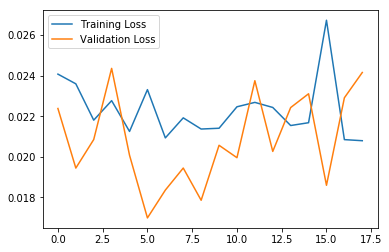

In [29]:
# sns.set()
loss_store = np.array(loss_store).T
print(loss_store.shape)
plt.plot(loss_store[0,:])
plt.plot(loss_store[1,:])
plt.legend(['Training Loss', 'Validation Loss']) # The losses here are only for the fine-tuning phase.

We now do the predictions an determine the test accuracy of the model.

(1972, 2) (1972, 64, 64) (1972, 2)
[ 957. 1015.]
Test accuracy:  0.9908722109533469
1 1
Target_label:  FLAIR
Predicted_label:  FLAIR
[1 0 0 ... 1 0 1] [1 0 0 ... 1 0 1]


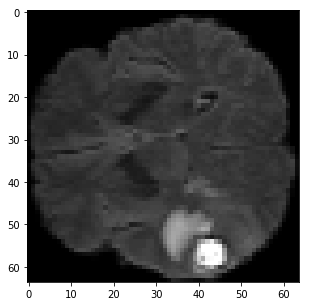

In [30]:
# finetuned_dict = torch.load(MODEL_PATH + 'VGG_weights_only_epoch5.pth')
# testclass_model = VGGClassModel(in_channels=1, out_channels=2, init_features=4)
# testclass_model.load_state_dict(finetuned_dict)

testclass_model = class_model

classification_results = []
testdata = []
testlabels = []
testclass_model.eval()

test_transform = ToTensor()

test_datadict = DatasetwithAug(testX, testy, test_transform)
test_dataloader = DataLoader(test_datadict, batch_size=1, shuffle=False, num_workers=0)
with torch.no_grad():
    for (data, label) in test_dataloader:
        data = data.to(device=device)
        label = label.to(device=device)
        data = Variable(data)
        label = Variable(label)
        preds = testclass_model.forward(data)
        classification_results.append(preds.detach().cpu().numpy())
        testdata.append(data.detach().cpu().numpy())
        testlabels.append(label.detach().cpu().numpy())
        
classification_results = np.array(classification_results).squeeze()
testdata = np.array(testdata).squeeze()
testlabels = np.array(testlabels).squeeze()

print(classification_results.shape, testdata.shape, testlabels.shape)
print(np.sum(testlabels, axis=0))

classification_vector = np.argmax(classification_results, axis=1)
testlabel_vector = np.argmax(testlabels, axis=1)

correctly_predicted = (classification_vector == testlabel_vector).astype(float)
accuracy = np.sum(correctly_predicted)/classification_results.shape[0]

print('Test accuracy: ', accuracy)

# print(classification_results,testlabels)

subj = 100
# sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,5))
plt.imshow(testdata[subj,:,:], cmap='gray')

sub_target_label = testlabel_vector[subj]
sub_pred_lab = classification_vector[subj]

target_label = 'FLAIR' if sub_target_label else 'T1'
predicted_label = 'FLAIR' if sub_pred_lab else 'T1'
print(sub_target_label, sub_pred_lab)
print('Target_label: ', target_label)
print('Predicted_label: ', predicted_label)

print(testlabel_vector, classification_vector)

As already mentioned, we can observe a slight improvement in accuracy with fine-tuning the trained model on the same training dataset. This could be one of the ways to boost accuracy and has been shown to work in few cases. However, it is always good to check the accuracy on the held-out validation dataset and repeat the fine-tuning a few times to check it actually works.